# Phys-321 Final Project

## Tal Sharoni, Justin Lipper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from astropy import units as u
from astropy.visualization import astropy_mpl_style
from scipy.integrate import trapz
import scipy.stats as stats
from scipy.optimize import curve_fit
import corner
import emcee
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# to compare to our Solar System
solar_system_radius = [0.383, 0.949, 1, 0.532, 11.21, 9.45, 4.01, 3.88]
solar_system_stellar_rad = [1]
solar_system_semimajor_axis = [0.387, 0.723, 1, 1.52, 5.20, 9.57, 19.17, 30.18]
solar_system_orbital_period = [88.0,224.7,365.2,687.0,4331,10747,30589,59800]

In [3]:
def parse_data(filename):
    radius = []
    stellar_rad = []
    orbital_period = []
    orbit_sma = []
    methods=[]
    #mass=[]
    ##stellar_mass[]
    with open(filename, 'r') as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            if row[0].startswith('#'):
                continue
            if row[0] == 'pl_name':
                continue
            else:
                if (row[21] == '') or (row[26] == '') or (row[19] == '') or (row[20] == ''):
                    continue
                if row[4]=='Transit' or row[4]=='Radial Velocity':
                    # filtering data since there are some extreme outliers in those fields
                    if (float(row[19]) <= 600) and (float(row[20]) <= 1):
                        radius.append(float(row[21]))
                        stellar_rad.append(float(row[26]))
                        orbital_period.append(float(row[19]))
                        orbit_sma.append(float(row[20]))
                        methods.append(row[4])
                    
    return radius, stellar_rad, orbital_period, orbit_sma, methods           

In [31]:
def filter(sun_radius, stellar_rad, radius, orbital_period, orbit_sma, weigths=None):
    filtered_radius = []
    filtered_orbital_period = []
    filtered_orbit_sma = []
    filtered_weigths = []
    for i in range(len(stellar_rad)):
        if stellar_rad[i] >= (sun_radius - 0.1) and stellar_rad[i] <= (sun_radius + 0.1):
            filtered_radius.append(radius[i])
            filtered_orbital_period.append(orbital_period[i])
            filtered_orbit_sma.append(orbit_sma[i])
            if weigths is not None:
                filtered_weigths.append(weigths[i])
    return filtered_radius, filtered_orbital_period, filtered_orbit_sma, filtered_weigths

In [5]:
radius, stellar_rad, orbital_period, orbit_sma, methods = parse_data('./PSCompPars_2024.03.30_12.22.56.csv')

First, we would like to create a likelihood model for the data, we will do so by fitting the distribution of all the parameters. We can start by plotting histograms of each parameter, and fitting a function to it. Some x domains will be cut off since there are significant outliers with extreme data, and we would like to see the trends of the distributions but those outliers will still be considered for later in the data analysis. Some of the data was also filtered to be able to bin it appropriately. The fitted fuction will be used as likelihood functions.

[ 2.01461182  0.91972994 12.72804135  3.03892234  0.77718007]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



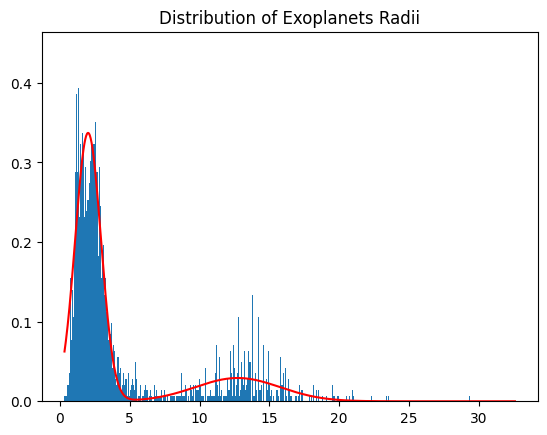

In [6]:
plt.hist(radius, bins=1000, density=True);
plt.title('Distribution of Exoplanets Radii')
def bimodal(x, mu1, sigma1, mu2, sigma2, w1):
    return (w1 * (1 / np.sqrt(2 * np.pi * sigma1**2)) * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
            + (1 - w1) * (1 / np.sqrt(2 * np.pi * sigma2**2)) * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

hist, bins = np.histogram(radius, bins=1000, density=True)
bin_centers_radius = (bins[:-1] + bins[1:]) / 2

initial_guess = [2, 2, 8, 12, 0.5]
popt, pcov = curve_fit(bimodal, bin_centers_radius, hist, p0=initial_guess)
planet_radius_distribution_params=popt
planet_radius_distribution_model=bimodal
print(popt)
plt.plot(bin_centers_radius, bimodal(bin_centers_radius, *popt), 'r-', label='Fit')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Distribution of Exoplanets Staller Radii, Cut Domain')

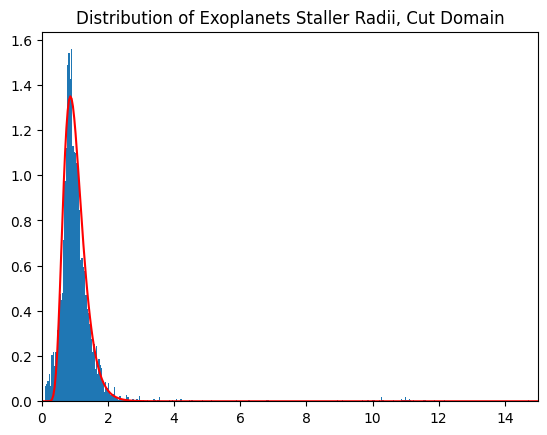

In [7]:
plt.hist(stellar_rad, bins=1000, density=True);
plt.xlim(0, 15)

def lognormal(x, m, sigma):
    return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))

hist, bins = np.histogram(stellar_rad, bins=1000, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 1]
popt, pcov = curve_fit(lognormal, bin_centers, hist, p0=initial_guess)
stellar_radius_distribution_params=popt
stellar_radius_distribution_model=lognormal
plt.plot(bin_centers, lognormal(bin_centers, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Staller Radii, Cut Domain')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_12685/1077711426.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Orbital Period')

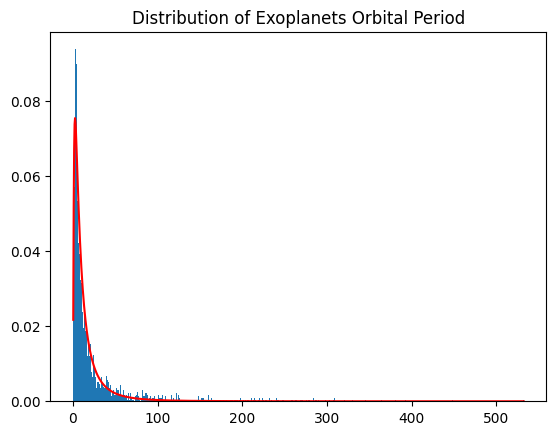

In [8]:
plt.hist(orbital_period, bins=1000, density=True);


hist, bins = np.histogram(orbital_period, bins=1000, density=True);
bin_centers_period = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers_period, hist, p0=initial_guess)
orbital_period_distribution_params=popt
orbital_period_distribution_model=lognormal
plt.plot(bin_centers_period, lognormal(bin_centers_period, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Orbital Period')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_12685/1077711426.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Semi Major Axis')

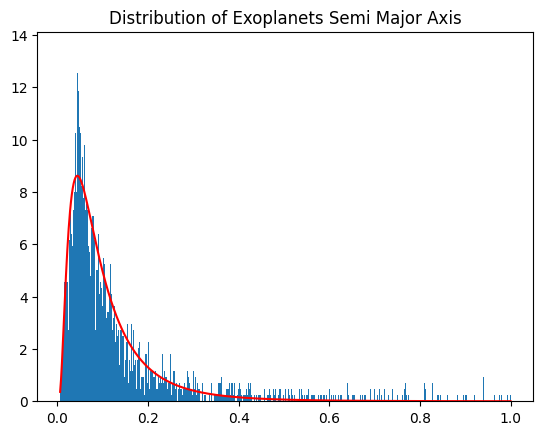

In [9]:
plt.hist(orbit_sma, bins=1000, density=True);

hist, bins = np.histogram(orbit_sma, bins=1000, density=True)
bin_centers_a = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers_a, hist, p0=initial_guess)
semimajor_axis_distribution_params=popt
semimajor_axis_distribution_model=lognormal
plt.plot(bin_centers_a, lognormal(bin_centers_a, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Semi Major Axis')

We will use a Bayesian analysis to analysis the validity of our model

## Model Selection Analysis

In [10]:
def likelihood(params, model, data, n_params):
    likelihood = 1
    if n_params == 5:
        for point in data:
            likelihood *= model(point, params[0], params[1], params[2], params[3], params[4])
    else:
        for point in data:
            likelihood *= model(point, params[0], params[1])
    return likelihood

In [11]:
likelihood_rPlanet = likelihood(planet_radius_distribution_params, planet_radius_distribution_model, solar_system_radius, 5)

likelihood_stellar_radii = likelihood(stellar_radius_distribution_params, stellar_radius_distribution_model, solar_system_stellar_rad, 2)

likelihood_orbital_period = likelihood(orbital_period_distribution_params, orbital_period_distribution_model, solar_system_orbital_period, 2)

likelihood_semimajor_axis = likelihood(semimajor_axis_distribution_params, semimajor_axis_distribution_model, solar_system_semimajor_axis, 2)

print("Model selection result for exoplanets radii:", "\n", likelihood_rPlanet, "\n", "--------------------------------")

print("Model selection result for exoplanets stellar radii:", "\n", likelihood_stellar_radii, "\n", "--------------------------------")

print("Model selection result for exoplanets orbital period:", "\n", likelihood_orbital_period, "\n", "--------------------------------")

print("Model selection result for exoplanets semi major axis:", "\n", likelihood_semimajor_axis, "\n", "--------------------------------")

Model selection result for exoplanets radii: 
 1.2137892885886029e-10 
 --------------------------------
Model selection result for exoplanets stellar radii: 
 1.219981024031515 
 --------------------------------
Model selection result for exoplanets orbital period: 
 1.6956635713382906e-80 
 --------------------------------
Model selection result for exoplanets semi major axis: 
 2.7736842641854482e-53 
 --------------------------------


Now, we will compare our uncorrected data with the planets in our solar system

In [25]:
filtered_radius, filtered_orbital_period, filtered_orbit_sma, _ = filter(1, stellar_rad, radius, orbital_period, orbit_sma)
print("Out of the original data set, " + str(round(len(filtered_radius)/len(radius), 5)) + "% of it has sun-like radius")

Out of the original data set, 0.24819% of it has sun-like radius


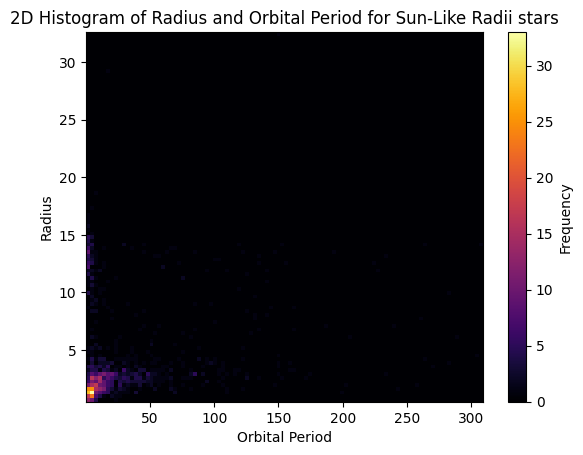

In [13]:
plt.hist2d(filtered_orbital_period, filtered_radius, bins=100, cmap='inferno');
plt.xlabel('Orbital Period')
plt.ylabel('Radius')
plt.title('2D Histogram of Radius and Orbital Period for Sun-Like Radii stars')
plt.colorbar(label='Frequency')

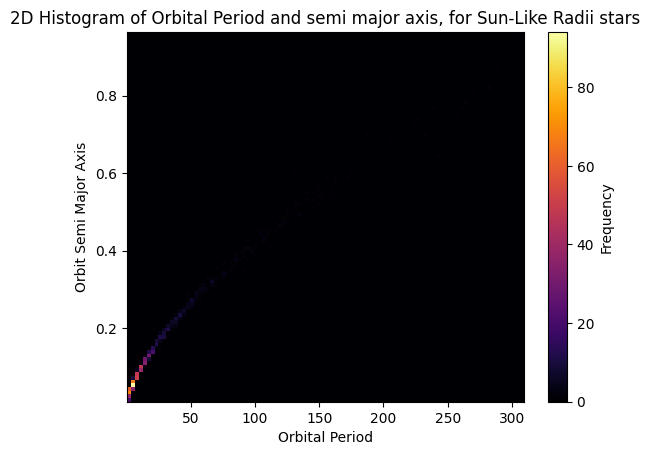

In [14]:
plt.hist2d(filtered_orbital_period, filtered_orbit_sma, bins=100, cmap='inferno');
plt.xlabel('Orbital Period')
plt.ylabel('Orbit Semi Major Axis')
plt.title('2D Histogram of Orbital Period and semi major axis, for Sun-Like Radii stars')
plt.colorbar(label='Frequency')

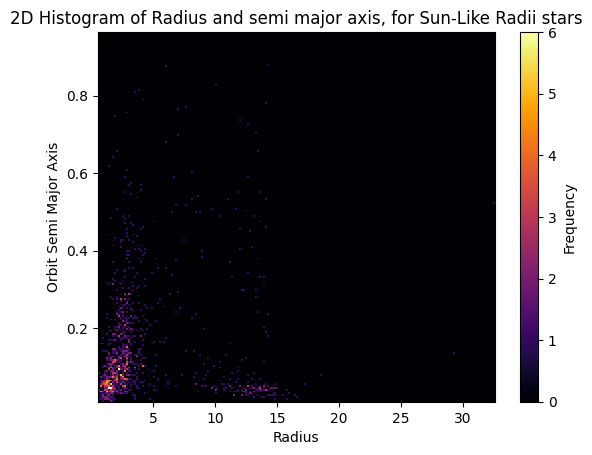

In [15]:
plt.hist2d(filtered_radius, filtered_orbit_sma, bins=200, cmap='inferno');
plt.xlabel('Radius')
plt.ylabel('Orbit Semi Major Axis')
plt.title('2D Histogram of Radius and semi major axis, for Sun-Like Radii stars')
plt.colorbar(label='Frequency')

### Correcting the bias

In [16]:
radii_bias=[]
for i in range(len(radius)):
    if methods[i]=='Transit':
        radii_bias.append((radius[i]/stellar_rad[i])**(5/2))
    elif methods[i]=='Radial Velocity':
        radii_bias.append((radius[i]**3)/(stellar_rad[i]**3+radius[i]**3)*(stellar_rad[i]**3+radius[i]**3)**0.5*(2)**0.5)


In [34]:
orbital_period_bias=[]
for i in range(len(orbital_period)):
    if methods[i]=='Transit':
        orbital_period_bias.append((1/orbital_period[i])*365.2)
    elif methods[i]=='Radial Velocity':
        orbital_period_bias.append(365.2**(1/3)*1/(orbital_period[i]**(1/3)))

correction_list = np.array(radii_bias) ** -1 * np.array(orbital_period_bias) ** -1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
[1.21689666 0.27252095 2.11231352 0.97724411 0.24359146]


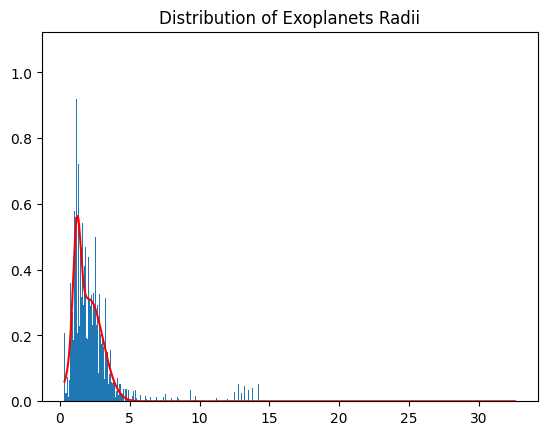

In [18]:
plt.hist(radius, bins=1000, weights=correction_list, density=True);
plt.title('Distribution of Exoplanets Radii')
def bimodal(x, mu1, sigma1, mu2, sigma2, w1):
    return (w1 * (1 / np.sqrt(2 * np.pi * sigma1**2)) * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
            + (1 - w1) * (1 / np.sqrt(2 * np.pi * sigma2**2)) * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

hist, bins = np.histogram(np.array(radius), bins=1000, weights=np.array(radii_bias)**-1*np.array(orbital_period_bias)**-1, density=True)
plt.plot()
bin_centers_radius = (bins[:-1] + bins[1:]) / 2
initial_guess = [2, 5, 12, 5, 0.5]
popt, pcov = curve_fit(bimodal, bin_centers_radius, hist, p0=initial_guess)
planet_radius_distribution_params=popt
planet_radius_distribution_model=bimodal
print(popt)
plt.plot(bin_centers_radius, bimodal(bin_centers_radius, *popt), 'r-', label='Fit')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Distribution of Exoplanets Staller Radii, Cut Domain')

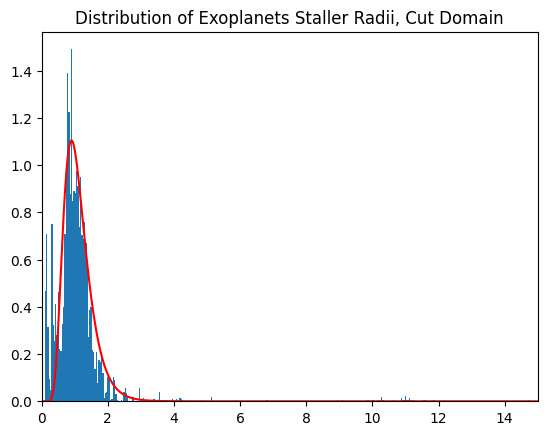

In [19]:
plt.hist(stellar_rad, bins=1000, weights=correction_list, density=True);
plt.xlim(0, 15)

def lognormal(x, m, sigma):
    return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))

hist, bins = np.histogram(stellar_rad, bins=1000, weights=np.array(radii_bias)**-1*np.array(orbital_period_bias)**-1, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 1]
popt, pcov = curve_fit(lognormal, bin_centers, hist, p0=initial_guess)
stellar_radius_distribution_params=popt
stellar_radius_distribution_model=lognormal
plt.plot(bin_centers, lognormal(bin_centers, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Staller Radii, Cut Domain')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_12685/1126389678.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Orbital Period, After Filtering')

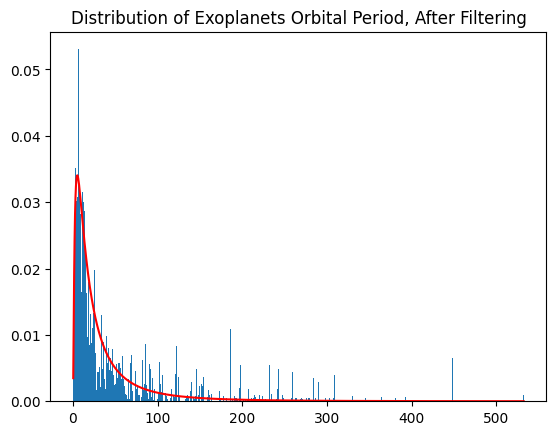

In [20]:
plt.hist(orbital_period, bins=1000, weights=correction_list, density=True);

hist, bins = np.histogram(orbital_period, bins=1000, weights=correction_list, density=True)
bin_centers_period = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers_period, hist, p0=initial_guess)
orbital_period_distribution_params=popt
orbital_period_distribution_model=lognormal
plt.plot(bin_centers_period, lognormal(bin_centers_period, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Orbital Period, After Filtering')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/jh/d8h7s0n16njgw7y93p_m379m0000gn/T/ipykernel_12685/1126389678.py:5: RuntimeWarning: invalid value encountered in log
  return (1 / (x * np.sqrt(2 * np.pi * sigma ** 2))) * np.exp(- (np.log(x) - np.log(m)) ** 2 / (2 * sigma ** 2))


Text(0.5, 1.0, 'Distribution of Exoplanets Semi Major Axis, After Filtering')

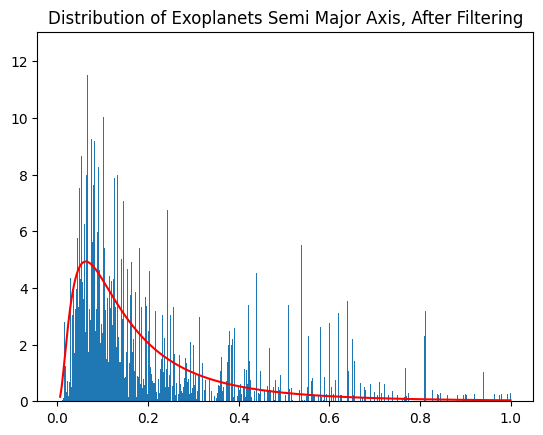

In [21]:
plt.hist(orbit_sma, bins=1000, weights=correction_list, density=True);

hist, bins = np.histogram(orbit_sma, bins=1000, weights=correction_list, density=True)
bin_centers_a = (bins[:-1] + bins[1:]) / 2

initial_guess = [0.5, 20]
popt, pcov = curve_fit(lognormal, bin_centers_a, hist, p0=initial_guess)
semimajor_axis_distribution_params=popt
semimajor_axis_distribution_model=lognormal
plt.plot(bin_centers_a, lognormal(bin_centers_a, *popt), 'r-', label='Fit')

plt.title('Distribution of Exoplanets Semi Major Axis, After Filtering')

In [22]:
likelihood_rPlanet = likelihood(planet_radius_distribution_params, planet_radius_distribution_model, solar_system_radius, 5)

likelihood_stellar_radii = likelihood(stellar_radius_distribution_params, stellar_radius_distribution_model, solar_system_stellar_rad, 2)

likelihood_orbital_period = likelihood(orbital_period_distribution_params, orbital_period_distribution_model, solar_system_orbital_period, 2)

likelihood_semimajor_axis = likelihood(semimajor_axis_distribution_params, semimajor_axis_distribution_model, solar_system_semimajor_axis, 2)

print("Model selection result for exoplanets radii:", "\n", likelihood_rPlanet, "\n", "--------------------------------")

print("Model selection result for exoplanets stellar radii:", "\n", likelihood_stellar_radii, "\n", "--------------------------------")

print("Model selection result for exoplanets orbital period:", "\n", likelihood_orbital_period, "\n", "--------------------------------")

print("Model selection result for exoplanets semi major axis:", "\n", likelihood_semimajor_axis, "\n", "--------------------------------")

Model selection result for exoplanets radii: 
 2.444156475383611e-38 
 --------------------------------
Model selection result for exoplanets stellar radii: 
 1.0629150712033035 
 --------------------------------
Model selection result for exoplanets orbital period: 
 2.378778753552452e-66 
 --------------------------------
Model selection result for exoplanets semi major axis: 
 1.696450675799784e-35 
 --------------------------------


In [35]:
filtered_radius, filtered_orbital_period, filtered_orbit_sma, correction_list = filter(1, stellar_rad, radius, orbital_period, orbit_sma, correction_list)

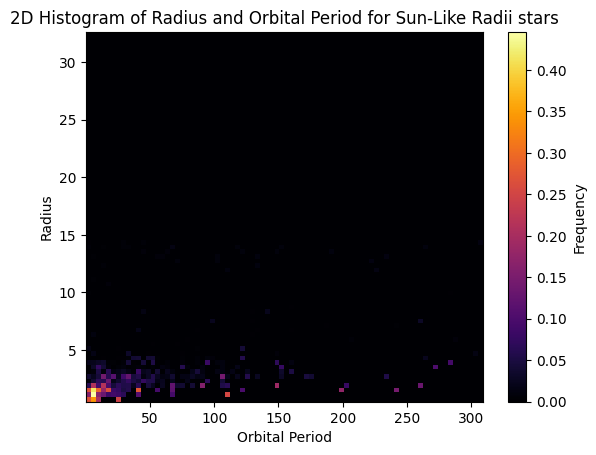

In [40]:
plt.hist2d(filtered_orbital_period, filtered_radius, weights=correction_list, bins=80, cmap='inferno');
plt.xlabel('Orbital Period')
plt.ylabel('Radius')
plt.title('2D Histogram of Radius and Orbital Period for Sun-Like Radii stars')
plt.colorbar(label='Frequency')

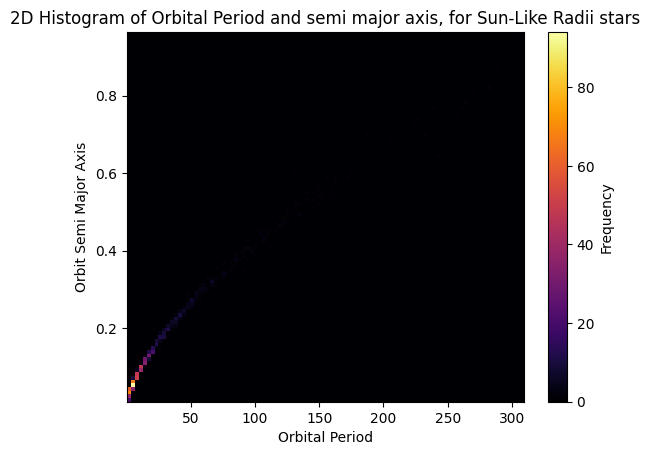

In [41]:
plt.hist2d(filtered_orbital_period, filtered_orbit_sma, bins=100, cmap='inferno');
plt.xlabel('Orbital Period')
plt.ylabel('Orbit Semi Major Axis')
plt.title('2D Histogram of Orbital Period and semi major axis, for Sun-Like Radii stars')
plt.colorbar(label='Frequency')

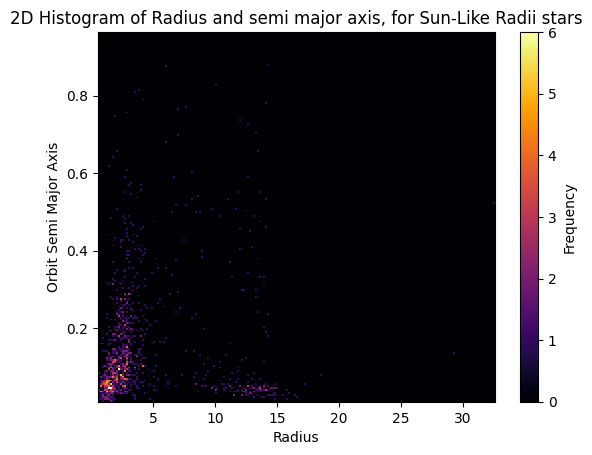

In [42]:
plt.hist2d(filtered_radius, filtered_orbit_sma, bins=200, cmap='inferno');
plt.xlabel('Radius')
plt.ylabel('Orbit Semi Major Axis')
plt.title('2D Histogram of Radius and semi major axis, for Sun-Like Radii stars')
plt.colorbar(label='Frequency')